<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/standartization/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive

import numpy as np

import pandas as pd

import os

In [2]:
%%capture
!pip install catboost

## PEP8 standard

In [3]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [4]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}


git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [5]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model


def reload_modules(modules):
    for module in modules:
        importlib.reload(module)


reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils,
        model
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from model import Model
from sklearn_utils import fit_grid_search
from sklearn_utils import dict_subset

# Set up paths

In [6]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 7
MODELS_TRIAL = 7
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_7 already exists


# Fixing seed

In [7]:
RANDOM_SEED = 42
RANDOM_STATE = RANDOM_SEED

np.random.seed(42)

# Download the data

In [8]:
os.listdir(manager.data_trial_path)

['trainval_processed.csv', 'test_sample_processed.csv', 'test_processed.csv']

In [9]:
df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_processed.csv'
    )
)
print(df_trainval.shape)

X_trainval = df_trainval.values[:, :-1]
Y_trainval = df_trainval.values[:, -1]

(6954, 29)


In [10]:
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    )
)
print(df_test_sample.shape)

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

(1739, 29)


In [11]:
df_trainval.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,0,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-1.996149,1.0,0.0,0.0,...,0.089399,0.0,0.0,1.0,0.0,2.392570,3.130413,-0.277637,1.0,1.0
1,1,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.811703,1.0,0.0,0.0,...,-0.747401,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.226031,1.0,1.0
2,2,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,0.442416,1.0,0.0,0.0,...,1.753246,0.0,0.0,1.0,1.0,-0.490454,-0.650221,1.716911,0.0,0.0
3,3,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.184643,0.0,1.0,0.0,...,-0.819573,0.0,0.0,1.0,1.0,-0.490454,-0.650221,0.304434,1.0,1.0
4,4,-0.459516,-0.409755,-0.214310,-0.427099,3.432164,-1.090396,1.0,0.0,0.0,...,0.456108,0.0,1.0,0.0,1.0,-0.490454,-0.650221,0.174835,1.0,0.0


# Define models

In [12]:
from sklearn.linear_model import LogisticRegression

In [22]:
LogReg = Model(
    LogisticRegression(),
    'LogReg',
    [
        {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.05, 0.1],
            'random_state': [RANDOM_STATE],
            'solver': ['saga'],
            'l1_ratio': [0, 0.01, 0.05]
        }
    ],
    [

    ]
)

In [23]:
from sklearn.ensemble import RandomForestClassifier


RandomForest = Model(
    RandomForestClassifier(),
    'RandomForest',
    [
        {
            'n_estimators': [75, 125],
            'max_depth': [6],
            'bootstrap': [True],
            'max_features': ['sqrt', 'log2'],
            'random_state': [42],
            'n_jobs': [-1]
        }
    ],
    [

    ]
)

In [24]:
from sklearn.svm import SVC


SVM = Model(
    SVC(),
    'SVM',
    [
        {
            'C': [0.05, 0.1, 0.5, 1.0],
            'kernel': ['linear', 'rbf', 'poly'],
            'random_state': [RANDOM_STATE]
        }
    ],
    [
        
    ]
)

In [25]:
from lightgbm import LGBMClassifier


light_gbm_model = Model(
    LGBMClassifier(),
    'LGBM',
    [
        {
            'objective': ['binary'],
            'random_state': [RANDOM_STATE],
            'boosting': ['dart'],
            'learning_rate': [0.1, 0.15],
            'max_depth': [3, 4],
            'n_estimators': [100, 150, 300],
            'lambda_l1': [0.07],
            'lambda_l2': [0.07]
        }
    ],
    []
)

In [26]:
all_models = {
    model.name: model
    for model in [
        LogReg,
        RandomForest,
        light_gbm_model,
        SVM
    ]
}

# Shortlist models based on cross-validation behavior

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model           Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
------------  ----------------------  ----------------  ------------------------  ------------------
SVM                         0.504853        0.00133805                  0.504603          0.00663384
LGBM                        0.913           0.00248165                  0.785877          0.0120308
LogReg                      0.790265        0.00219184                  0.78818           0.00711171
RandomForest                1               0                           0.790194          0.00794913


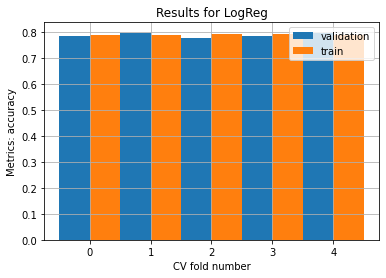

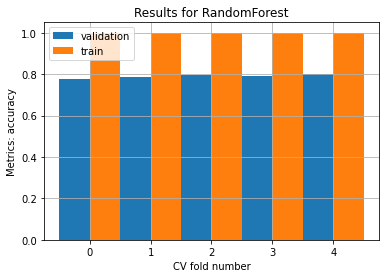

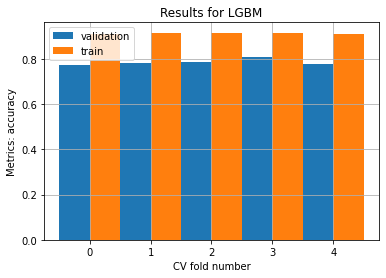

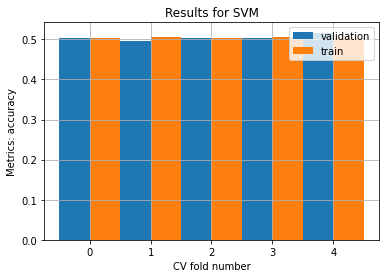

In [19]:
from sklearn_utils import plot_cv_results


np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model
        for model_name, model in all_models.items()
    },
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',  # 'accuracy'
    to_put_minus_=False
)

In [28]:
shortlisted_models = {
    model.name: model
    for model in [
        LogReg,
        # SVM,
        RandomForest,
        light_gbm_model
    ]
}

# Fine tune shortlisted models with grid search

## Random forest

Fitting RandomForest
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   1.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=125, n_jobs=-1, random_state=42; total time=   0.7s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=125, n_jobs=-1, random_state=42; total time=   0.7s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=

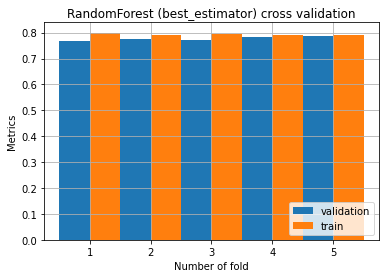

In [29]:
rf_results = fit_grid_search(
    models_dict_=dict_subset(
        shortlisted_models,
        ['RandomForest']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [30]:
rf_results['RandomForest'].best_score_, \
    rf_results['RandomForest'].best_params_

(0.7772520157849279,
 {'bootstrap': True,
  'max_depth': 6,
  'max_features': 'sqrt',
  'n_estimators': 75,
  'n_jobs': -1,
  'random_state': 42})

## SVM

In [ ]:
from sklearn.svm import SVC

svm_model = Model(
    SVC(),
    'SVM',
    [
        {
            'random_state': [42],
            'kernel': ['linear']
        },
    ],
    []
)

In [ ]:
from sklearn_utils import fit_grid_search


svm_results = fit_grid_search(
    {'SVM': svm_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=5
)

Fitting SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# svm_results.best_score_

## Gradient boosting

In [31]:
from sklearn.ensemble import GradientBoostingClassifier


xgb_model = Model(
    GradientBoostingClassifier(),
    'XGB',
    [
        {
            'n_estimators': [100, 150],
            'random_state': [42],
            'learning_rate': [0.05],
            'max_depth': [3],
            'max_features': [None, 'sqrt', 'log2']
        }
    ],
    []
)

Fitting XGB
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=150, random_state=42; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=150, random_state=42; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=150, random_state=42; total time=   2.1s
[CV] END

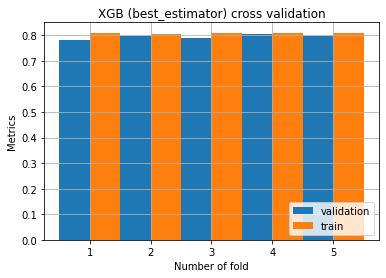

In [32]:
xgb_results = fit_grid_search(
    models_dict_={'XGB': xgb_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [33]:
xgb_results['XGB'].best_score_, \
    xgb_results['XGB'].best_params_

(0.7937880206259148,
 {'learning_rate': 0.05,
  'max_depth': 3,
  'max_features': None,
  'n_estimators': 100,
  'random_state': 42})

## Adaptive boosting

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


ada_boost = Model(
    AdaBoostClassifier(),
    'AdaBoost',
    [
        {
            'n_estimators': [50, 100],
            'random_state': [42],
            'base_estimator': [
                # DecisionTreeClassifier(max_depth=2),
                DecisionTreeClassifier(
                    max_depth=3,
                    random_state=RANDOM_STATE,
                    # bootstrap=True
                ),
                # LogisticRegression(random_state=RANDOM_STATE)

            ],
            'learning_rate': [0.05]
        }
    ],
    [

    ]
)

Fitting AdaBoost
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=100, random_state=42; total time=   2.5s
[CV] END base_es

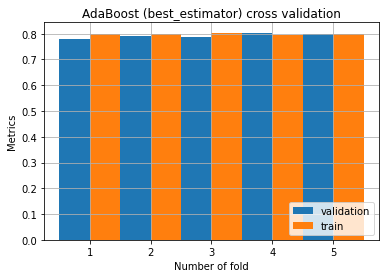

In [47]:
ada_boost_results = fit_grid_search(
    models_dict_={'AdaBoost': ada_boost},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [48]:
ada_boost_results['AdaBoost'].best_score_, \
    ada_boost_results['AdaBoost'].best_params_

(0.791488138030194,
 {'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=42),
  'learning_rate': 0.05,
  'n_estimators': 50,
  'random_state': 42})

## CatBoost

In [49]:
from catboost import CatBoostClassifier


cat_boost_model = Model(
    CatBoostClassifier(),
    'CatBoost',
    [
        {
            'n_estimators': [150],
            'depth': [5],
            'reg_lambda': [0.01],
            'verbose': [0],
            'random_state': [42]
        }
    ],
    []
)

Fitting CatBoost
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END depth=5, n_estimators=150, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.7s
[CV] END depth=5, n_estimators=150, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.6s
[CV] END depth=5, n_estimators=150, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.6s
[CV] END depth=5, n_estimators=150, random_state=42, reg_lambda=0.01, verbose=0; total time=   1.1s
[CV] END depth=5, n_estimators=150, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.6s


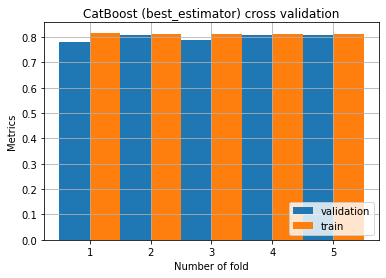

In [50]:
cat_boost_results = fit_grid_search(
    {'CatBoost': cat_boost_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [52]:
cat_boost_results['CatBoost'].best_score_, \
    cat_boost_results['CatBoost'].best_params_

(0.7975278899813291,
 {'depth': 5,
  'n_estimators': 150,
  'random_state': 42,
  'reg_lambda': 0.01,
  'verbose': 0})

## LogReg

Fitting LogReg
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

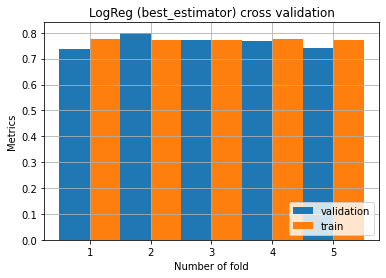

In [ ]:
from sklearn_utils import fit_grid_search


log_reg_results = fit_grid_search(
    dict_subset(
        shortlisted_models,
        ['LogReg']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=1
)

In [ ]:
log_reg_results['LogReg'].best_score_, \
    log_reg_results['LogReg'].best_params_

(0.7635858473537489,
 {'C': 0.01,
  'l1_ratio': 0,
  'penalty': 'elasticnet',
  'random_state': 42,
  'solver': 'saga'})

## Light GBM

Fitting LGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.802, test=0.779) total time=   0.2s
[CV 2/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.800, test=0.792) total time=   0.2s
[CV 3/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.807, test=0.785) total time=   0.2s
[CV 4/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.799, test=0.805) total time=   0.2s
[CV 5/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_sta

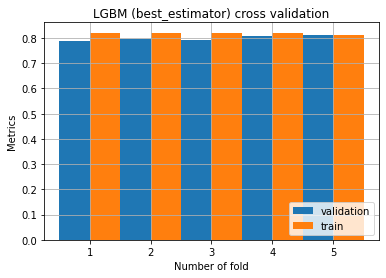

In [53]:
from sklearn_utils import fit_grid_search


light_gbm_results = fit_grid_search(
    dict_subset(
        all_models,
        ['LGBM']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=3
)

In [54]:
light_gbm_results['LGBM'].best_score_, \
    light_gbm_results['LGBM'].best_params_

(0.799541554391282,
 {'boosting': 'dart',
  'lambda_l1': 0.07,
  'lambda_l2': 0.07,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 150,
  'objective': 'binary',
  'random_state': 42})

## Stacking model

In [64]:
CatBoostClassifier(**cat_boost_results['CatBoost'].best_params_)

In [66]:
from sklearn.ensemble import StackingClassifier


stacking_model = Model(
    StackingClassifier(
        estimators = [
            ('catboost', CatBoostClassifier(**cat_boost_results['CatBoost'].best_params_)),
            ('lgbm', LGBMClassifier(**light_gbm_results['LGBM'].best_params_)),
            ('adaboost', AdaBoostClassifier(**ada_boost_results['AdaBoost'].best_params_))
        ]
    ),
    'Stacking',
    [
        {
            'cv': [5]
        }
    ],
    []
)

Fitting Stacking


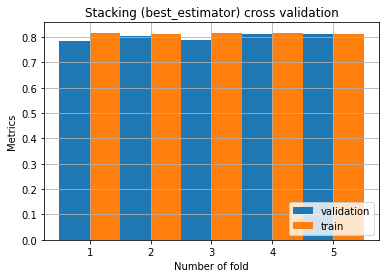

In [67]:
stacking_results = fit_grid_search(
    {
        'Stacking': stacking_model
    },
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy'
)

In [68]:
stacking_results['Stacking'].best_score_

0.7988224402505314

## Voting classifier

In [71]:
from sklearn.ensemble import VotingClassifier


voting_model = Model(
    VotingClassifier(
        estimators=[
            ('catboost', CatBoostClassifier(**cat_boost_results['CatBoost'].best_params_)),
            ('lgbm', LGBMClassifier(**light_gbm_results['LGBM'].best_params_)),
            ('adaboost', AdaBoostClassifier(**ada_boost_results['AdaBoost'].best_params_))
        ]
    ),
    'voting',
    [
        {
            'n_jobs': [-1],
            'voting': ['hard', 'soft']
        }
    ],
    []
)

Fitting voting
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END n_jobs=-1, voting=hard;, score=(train=0.814, test=0.779) total time=   3.7s
[CV 2/5] END n_jobs=-1, voting=hard;, score=(train=0.809, test=0.804) total time=   2.0s
[CV 3/5] END n_jobs=-1, voting=hard;, score=(train=0.811, test=0.790) total time=   2.3s
[CV 4/5] END n_jobs=-1, voting=hard;, score=(train=0.811, test=0.807) total time=   2.1s
[CV 5/5] END n_jobs=-1, voting=hard;, score=(train=0.808, test=0.811) total time=   2.4s
[CV 1/5] END n_jobs=-1, voting=soft;, score=(train=0.816, test=0.781) total time=   3.6s
[CV 2/5] END n_jobs=-1, voting=soft;, score=(train=0.809, test=0.805) total time=   2.1s
[CV 3/5] END n_jobs=-1, voting=soft;, score=(train=0.813, test=0.789) total time=   2.1s
[CV 4/5] END n_jobs=-1, voting=soft;, score=(train=0.813, test=0.807) total time=   2.1s
[CV 5/5] END n_jobs=-1, voting=soft;, score=(train=0.810, test=0.807) total time=   2.1s


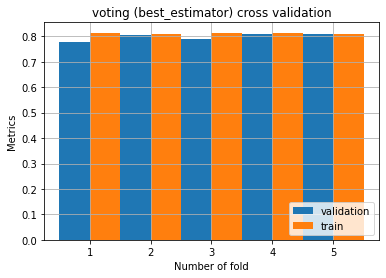

In [73]:
voting_results = fit_grid_search(
    {'voting': voting_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=3
)

In [74]:
voting_results['voting'].best_score_

0.7983911993338471

# Saving models

In [75]:
res_models = {
    # **log_reg_results,
    # **xgb_results
    # **light_gbm_results
    # **cat_boost_results
    **voting_results,
    **stacking_results
    # **rf_results
}
res_models

{'voting': GridSearchCV(cv=5,
              estimator=VotingClassifier(estimators=[('catboost',
                                                      <catboost.core.CatBoostClassifier object at 0x7f0731ea1190>),
                                                     ('lgbm',
                                                      LGBMClassifier(boosting='dart',
                                                                     lambda_l1=0.07,
                                                                     lambda_l2=0.07,
                                                                     max_depth=4,
                                                                     n_estimators=150,
                                                                     objective='binary',
                                                                     random_state=42)),
                                                     ('adaboost',
                                                      AdaB

In [76]:
manager.save_models(
    {
        f'{model_name}_gridsearch': result.best_estimator_
        for model_name, result in res_models.items()
    }
)